In [74]:
%cd ..

/Users/erwan/Programmes/2022 Datacamp


In [75]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from display import plot_event, multiple_plots, display_timeline, show_densities
from problem import get_train_data
from problem import turn_prediction_to_event_list

In [76]:
data_train, labels_train = get_train_data()
events = turn_prediction_to_event_list(labels_train)
no_events = turn_prediction_to_event_list(labels_train == 0)

data_train = data_train.drop(columns=['Range F 14']) # Ne contient pas de données


KeyboardInterrupt



In [ ]:
print("Colonnes d'entrées conservées pour model_v1 :")
cols = ['Beta', 'Pdyn', 'RmsBob', 'Vth']
v1_data_train = data_train[cols]

v1_pearson_corr = v1_data_train.corr('spearman')
v1_pearson_corr

Colonnes d'entrées conservées pour model_v1 :


,Beta,Pdyn,RmsBob,Vth
Beta,1.000000,0.306850,0.524559,0.432414
Pdyn,0.306850,1.000000,0.160890,0.176247
RmsBob,0.524559,0.160890,1.000000,0.525744
Vth,0.432414,0.176247,0.525744,1.000000


## Pré-traitement des données

In [79]:
# Standardisation 
seuil_beta = 40
seuil_rmsbob = 2.5
seuil_vth = 250
seuil_pdyn = 0.4 * 1e-12

thresh_beta_s = v1_data_train['Beta'].map(lambda x: min(x, 70))

In [ ]:
start = 10000
frac_beta_s = thresh_beta_s.iloc[start: start + 300]
labels = labels_train.iloc[start: start + 300]

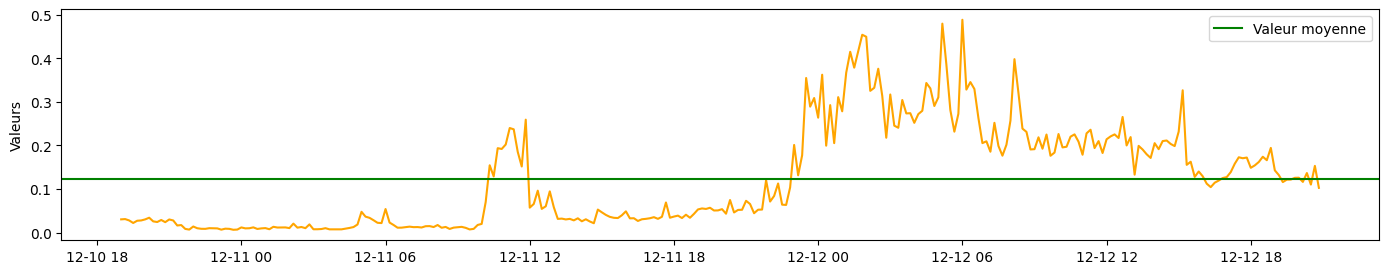

In [ ]:
display_timeline(frac_beta_s, labels)

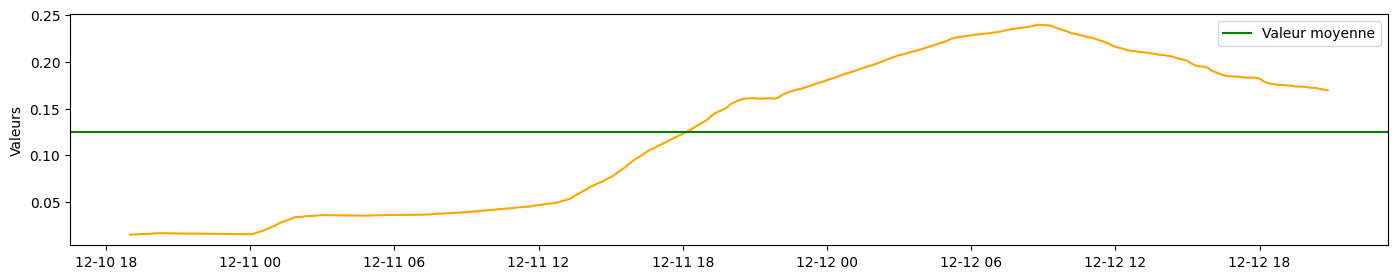

In [ ]:
display_timeline(frac_beta_s.rolling('20 h', center=True).mean(), labels)

In [ ]:
frac_beta_s

1997-12-10 19:00:00    0.030442
1997-12-10 19:10:00    0.031048
1997-12-10 19:20:00    0.027942
1997-12-10 19:30:00    0.022134
1997-12-10 19:40:00    0.027268
                         ...   
1997-12-12 20:10:00    0.116325
1997-12-12 20:20:00    0.136621
1997-12-12 20:30:00    0.110182
1997-12-12 20:40:00    0.153085
1997-12-12 20:50:00    0.102694
Name: Beta, Length: 300, dtype: float64

In [ ]:
avg_frac_beta = pd.DataFrame(columns=['Beta', 'Mv', 'Abs'])
avg_frac_beta['Beta'] = frac_beta_s.copy()
avg_frac_beta.head()

,Beta,Mv,Abs
1997-12-10 19:00:00,0.030442,NaN,NaN
1997-12-10 19:10:00,0.031048,NaN,NaN
1997-12-10 19:20:00,0.027942,NaN,NaN
1997-12-10 19:30:00,0.022134,NaN,NaN
1997-12-10 19:40:00,0.027268,NaN,NaN


In [ ]:
avg_frac_beta['Mv'] = frac_beta_s.rolling('20 h', center=True).mean()
avg_frac_beta.head(3)

,Beta,Mv,Abs
1997-12-10 19:00:00,0.030442,0.015222,NaN
1997-12-10 19:10:00,0.031048,0.015568,NaN
1997-12-10 19:20:00,0.027942,0.015860,NaN


In [ ]:
avg_frac_beta['Abs'] = (avg_frac_beta['Beta'] - avg_frac_beta['Mv']).abs()
avg_frac_beta.head(3)

,Beta,Mv,Abs
1997-12-10 19:00:00,0.030442,0.015222,0.015220
1997-12-10 19:10:00,0.031048,0.015568,0.015480
1997-12-10 19:20:00,0.027942,0.015860,0.012083


In [82]:
thresh_beta_s =  v1_data_train['Beta'].map(lambda x: min(x, seuil_beta))

In [83]:
thresh_and_stand_beta = (thresh_beta_s - thresh_beta_s.min()) / thresh_beta_s.max()

In [85]:
before_mean = thresh_and_stand_beta.to_frame()['Beta'].iloc[::-1].rolling('15 h').mean().iloc[::-1]
after_mean = thresh_and_stand_beta.to_frame()['Beta'].rolling('15 h', center=False).mean()
var_s_mean = thresh_and_stand_beta.to_frame()['Beta'].rolling('15 h', center=True).mean()

### Modèles

In [ ]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [86]:
data_ba = pd.DataFrame({'Beta': data_train['Beta'], 'bm': before_mean, 'am': after_mean})
data_m = pd.DataFrame({'Beta': data_train['Beta'], 'mean': var_s_mean})

In [88]:
model_ba = RandomForestClassifier(n_estimators=100)
model_ba.fit(data_ba, labels_train)

RandomForestClassifier()

In [90]:
model_ba.score(data_ba, labels)

ValueError: Found input variables with inconsistent numbers of samples: [300, 509834]

In [ ]:
model_m = RandomForestClassifier(n_estimators=100)


In [ ]:
model_m.fit(data_m, labels_train)


In [ ]:
model_ba = HistGradientBoostingClassifier(max_iter=1000)
model_m = HistGradientBoostingClassifier(max_iter=1000)

model_ba.fit(data_ba, labels_train)
model_m.fit(data_m, labels_train)